# Desarrollo M2

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
project_path = os.path.abspath('..')
sys.path.insert(1, project_path)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import pandas as pd
# import seaborn
# seaborn.set_context(context="talk")

from torch.utils.data import DataLoader

from src.data.dataset import lc_dataset
from src.models.model import periodicTransformer
from src.visualization.plots import plot_periodic
from src.data.curve_generator import random_periodic_sin_mix

## Objetivos

- [ ] Cambiar el codificador posicional actual (discreto) a uno continuo, puede ser el de T. Sousa o O. Pimentel
- [X] Probar con un conjunto más amplio de clases (curvas sinteticas), por lo que vi tienen dos clases por ahora, traten de extender el problema a almenos 4
- [ ] Realizar pruebas con curvas dobladas (en fase), curvas no dobladas y otras con fase aumentada (esto es simplemente entregar dos fases o tres, una tras la otra)
- [ ] Observar como se comportan los pesos de atención en el caso de series periodicas vs no periodicas, para esto recomiendo que dentro de las 4 clases periodicas que vayan a generar integren una quinta que sea no periodica, sería interesante ver como clasifica esta serie no periodica si el modelo fue entrenado con solo curvas periodicas
- [X] Esto es un poco más libre, pero generar algunas figuras como matrices de confusión, curvas roc, curvas de perdida o accuracy en el tiempo, visualización de el espacio de caracteristicas etc..

## Doblaje de curvas

### Generación de datos

In [3]:
train_data = lc_dataset()
train_data.add_curves('sinmix', N=800, seq_len=200, min_period=0.5, max_period=2, label=0, folded=True)
train_data.add_curves('sinmix', N=800, seq_len=200, min_period=5, max_period=10, label=1)
train_data.add_curves('sawtooth', N=800, seq_len=200, min_period=1.5, max_period=4, label=2, folded=True)
train_data.add_curves('square', N=800, seq_len=200, min_period=2, max_period=8, label=3)
# train_data.add_curves('gauss', N=800, seq_len=200, min_period=2, max_period=8, label=4, folded=True)

val_data = lc_dataset(seed=127)
val_data.add_curves('sinmix', N=300, seq_len=200, min_period=0.5, max_period=2, label=0, folded=True)
val_data.add_curves('sinmix', N=300, seq_len=200, min_period=5, max_period=10, label=1)
val_data.add_curves('sawtooth', N=300, seq_len=200, min_period=1.5, max_period=4, label=2, folded=True)
val_data.add_curves('square', N=300, seq_len=200, min_period=2, max_period=8, label=3)
# val_data.add_curves('gauss', N=300, seq_len=200, min_period=2, max_period=8, label=4, folded=True)

### Visualización del dataset

IndexError: single positional indexer is out-of-bounds

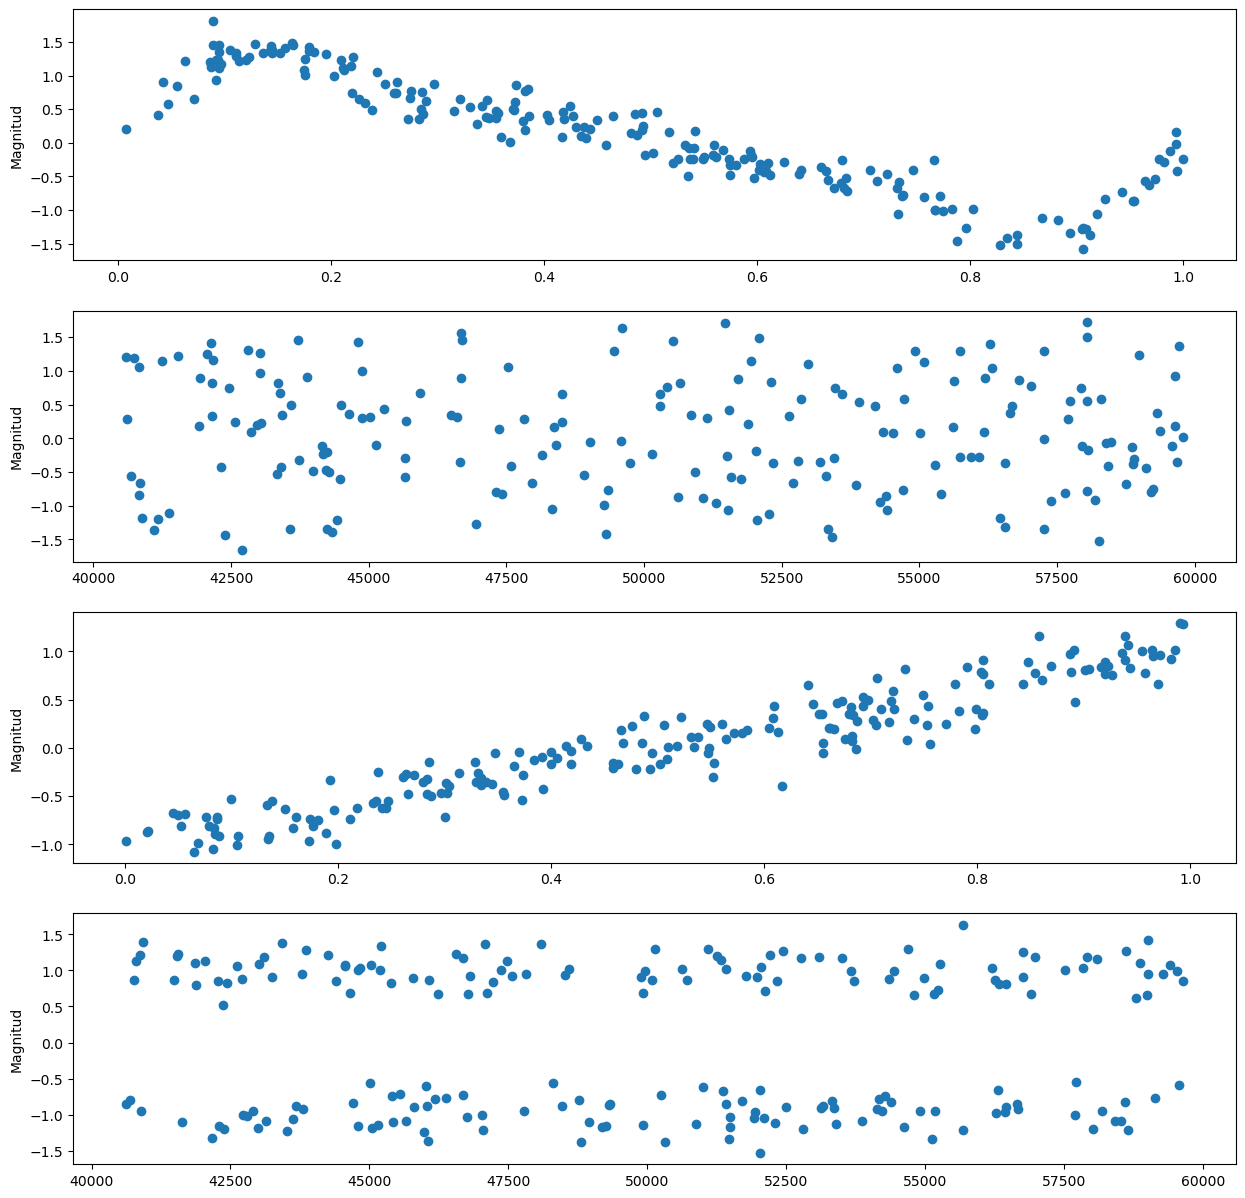

In [5]:
fig, ax = plt.subplots(4, figsize=(15,15))

for label in range(5):
    temp_data = train_data.to_df().loc[train_data.to_df()['label'] == label].iloc[0].copy()
    ax[label].scatter(temp_data.mjd, temp_data.mag)
    ax[label].set_ylabel('Magnitud')
ax[0].set_title('Clase 1 - Señal "sinmix1" - P = [0.5, 2]')
ax[1].set_title('Clase 2 - Señal "sinmix2" - P = [5,10]')
ax[2].set_title('Clase 3 - Señal "sawtooth" - P = [1.5,4]')
ax[3].set_title('Clase 4 - Señal "square" - P = [2,8]')
# ax[4].set_title('Clase 5 - Señal "gauss" - P = --')
plt.xlabel('Épocas')
plt.show()

### Clasificación

#### DataLoaders

In [6]:
batch_size = 64


train_loader = DataLoader(train_data,
                            batch_size=batch_size,
                            pin_memory=True,
                            num_workers=16,
                            shuffle=True)

val_loader = DataLoader(val_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16,
                        shuffle=True)                


#### Generación del modelo

In [7]:
n_classes = 5
n_blocks = 6

tmp_model = periodicTransformer(n_classes=n_classes, N=n_blocks, d_model=200, d_ff=2048, h=8, dropout=0.1)

/home/agonzalez/projects/el7006/Projecto-EL7006/src/models/model.py:25: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


#### Training

In [8]:
loss, val_loss = tmp_model.fit(train_loader, val_loader, 30)

Epoch: 0 - Train loss: 0.19516858458518982 - Val loss: 0.24330763518810272 - Val acc: 0.8333333134651184
Epoch: 1 - Train loss: 0.04426927492022514 - Val loss: 0.12332448363304138 - Val acc: 0.9375
Epoch: 2 - Train loss: 0.024077635258436203 - Val loss: 0.06886192411184311 - Val acc: 0.9583333134651184
Epoch: 3 - Train loss: 0.004488624166697264 - Val loss: 0.07491032034158707 - Val acc: 0.9375
Epoch: 4 - Train loss: 0.002491649938747287 - Val loss: 0.06973164528608322 - Val acc: 0.9791666865348816
Epoch: 5 - Train loss: 0.08303280919790268 - Val loss: 0.28207507729530334 - Val acc: 0.8958333134651184
Epoch: 6 - Train loss: 0.005601409822702408 - Val loss: 0.32342246174812317 - Val acc: 0.9166666865348816
Epoch: 7 - Train loss: 0.002187645761296153 - Val loss: 0.11826106160879135 - Val acc: 0.9791666865348816
Epoch: 8 - Train loss: 0.029468433931469917 - Val loss: 0.10672353953123093 - Val acc: 0.9583333134651184
Epoch: 9 - Train loss: 0.0009302554535679519 - Val loss: 0.06704571098089

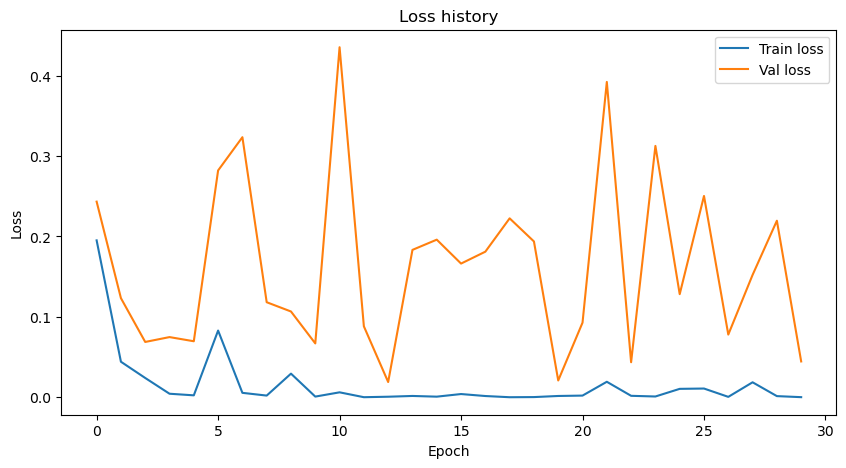

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(loss)
ax.plot(val_loss)
ax.set_title('Loss history')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train loss', 'Val loss'])
plt.show()

#### Testing

In [10]:
test_data = lc_dataset(seed=10)
test_data.add_curves('sinmix', N=200, seq_len=200, min_period=0.5, max_period=2, label=0, folded=True)
test_data.add_curves('sinmix', N=200, seq_len=200, min_period=5, max_period=10, label=1)
test_data.add_curves('sawtooth', N=200, seq_len=200, min_period=1.5, max_period=4, label=2, folded=True)
test_data.add_curves('square', N=200, seq_len=200, min_period=2, max_period=8, label=3)
# test_data.add_curves('gauss', N=200, seq_len=200, min_period=2, max_period=8, label=4)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        pin_memory=True,
                        num_workers=16,
                        shuffle=True)    

_, test_predictions = tmp_model.test(test_loader)
test_predictions = np.array(test_predictions)

Test batch acc: 0.9375
Test batch acc: 0.96875
Test batch acc: 1.0
Test batch acc: 0.953125
Test batch acc: 0.953125
Test batch acc: 0.984375
Test batch acc: 0.96875
Test batch acc: 0.953125
Test batch acc: 0.921875
Test batch acc: 0.921875
Test batch acc: 0.96875
Test batch acc: 0.96875
Test batch acc: 0.96875
Test avg acc: 0.9591346383094788


#### Matriz de confusión

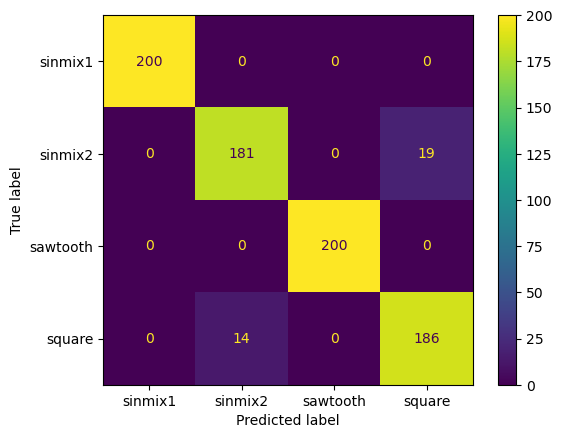

In [13]:
cm = confusion_matrix(
                    test_predictions[:,0],
                    test_predictions[:,1])
disp = ConfusionMatrixDisplay(
                            confusion_matrix=cm,
                            display_labels=[
                                'sinmix1',
                                'sinmix2',
                                'sawtooth',
                                'square'])
disp.plot()
plt.show()

#### Otras métricas

In [14]:
print(
    classification_report(
        test_predictions[:,0],
        test_predictions[:,1],
        target_names=['sinmix1', 'sinmix2', 'sawtooth', 'square']
        )
        )

              precision    recall  f1-score   support

     sinmix1       1.00      1.00      1.00       200
     sinmix2       0.93      0.91      0.92       200
    sawtooth       1.00      1.00      1.00       200
      square       0.91      0.93      0.92       200

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



## Propuesta a futuro

- Datos con tiempos en distintos intervalos
- Datos con distintos rangos de magnitudes
- Analizar como afecta desbalance